In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import get_matching_pairs, get_images, get_depths
from utils.calib_utils import detect_keypoints, undistort_intrinsics, to_homogeneous, to_cartesian, undistort_images, transform2local, plane2plane_transformation, to_norm_image_coord, project2image, compose_fund_mat, optimize_pose_lm, pointcloudify_depths, optimize_translation_lm, average_transforms
from utils.vis_utils import plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, plot_epipolar_lines, draw_chessboard_corners, normalize_image

np.set_printoptions(suppress=True)


### Load data

In [50]:
img_ext = '.png'
depth_ext = '.npy'
period = 1

In [53]:
# Data paths
# data_root = "/home/konstantin/datasets/bandeja-sequence/2021-04-12-18-02-47/"
# data_root = "/home/konstantin/datasets/bandeja-sequence/2021-04-12-20-30-05/"
data_root = "/home/konstantin/datasets/bandeja-sequence/2021-04-12-20-37-19/"

s10_images_path = data_root + "smartphone_video_frames"
azure_images_path = data_root + "_azure_ir_image_raw"
azure_depths_path = data_root + "_azure_depth_image_raw"

In [54]:
# Deterime matching pairs between s10 and azure either by matching or providing the list of timestamps manually
s10_timestamps, azure_timestamps = get_matching_pairs(s10_images_path, azure_images_path)

In [55]:
s10_images = get_images(s10_images_path, period=period, file_name_list=[fn + img_ext for fn in s10_timestamps])

In [56]:
azure_images = get_images(azure_images_path, period=period, file_name_list=[fn + img_ext for fn in azure_timestamps])
azure_depths = get_depths(azure_depths_path, period=period, file_name_list=[fn + depth_ext for fn in azure_timestamps])

In [57]:
s10_timestamps = s10_timestamps[::period]
azure_timestamps = azure_timestamps[::period]

In [58]:
# Load intrinsics cailbration results which should include intrinsics, distortion coefficients and undistorted intrinsics
s10_intrinsics_calib = np.load('calib_output/s10_standard_intrinsics.npy', allow_pickle=True).item()

s10_intrinsics = s10_intrinsics_calib['intrinsics']
s10_dist_coeff = s10_intrinsics_calib['dist_coeff']
s10_undist_intrinsics = s10_intrinsics_calib['undist_intrinsics']

In [59]:
# Stock calibration for azure
azure_intrinsics = np.array([[503.9581604003906, 0.0, 325.4591064453125],
                             [0.0, 504.0079345703125, 340.33404541015625],
                             [0.0, 0.0, 1.0]])

azure_dist_coeff = np.array([5.268435478210449, 3.5621509552001953, -6.14773682627856e-07, -4.438921678229235e-05, 0.1832902431488037, 5.597447872161865, 5.32110071182251, 0.9697896838188171])

azure_undist_intrinsics = undistort_intrinsics(next(iter(azure_images.values())).shape[::-1], azure_intrinsics, azure_dist_coeff)

In [60]:
# Undistort all data before the work
s10_images = undistort_images(s10_images, s10_intrinsics, s10_dist_coeff, s10_undist_intrinsics, cv.INTER_LINEAR)
azure_images = undistort_images(azure_images, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_LINEAR)

In [61]:
azure_depths = undistort_images(azure_depths, azure_intrinsics, azure_dist_coeff, azure_undist_intrinsics, cv.INTER_NEAREST)


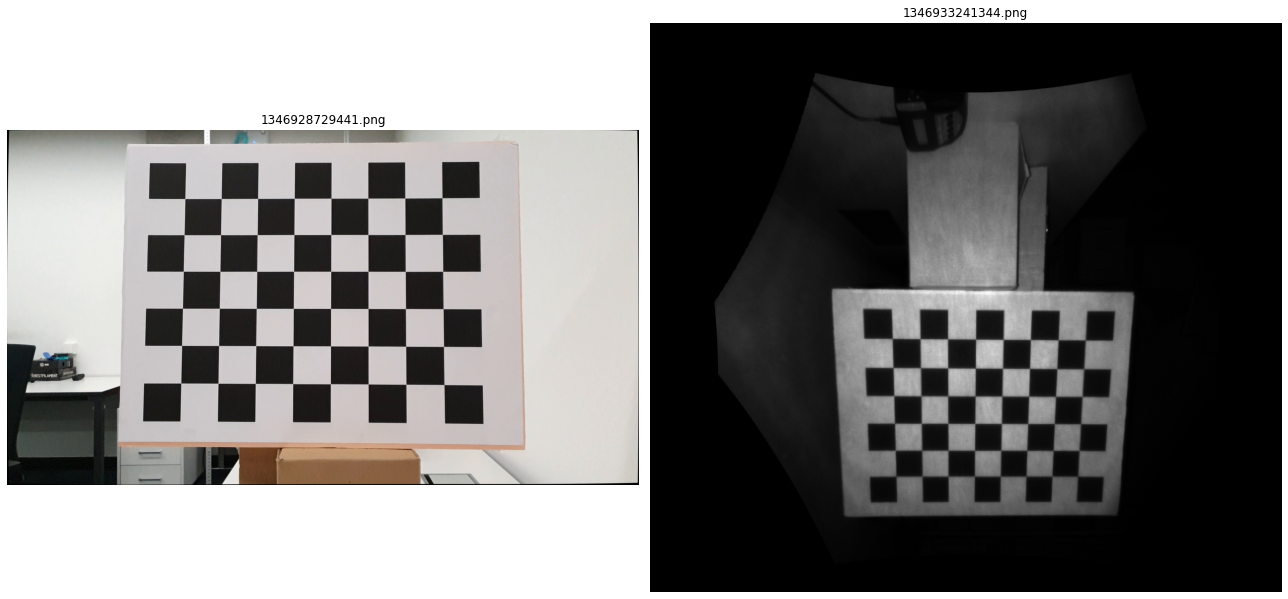

In [62]:
idx = 0

check_s10_key, check_azure_key = s10_timestamps[idx], azure_timestamps[idx]

plot_figures({check_s10_key + img_ext: s10_images[check_s10_key + img_ext], 
              check_azure_key + img_ext: azure_images[check_azure_key + img_ext]}, 1, 2)

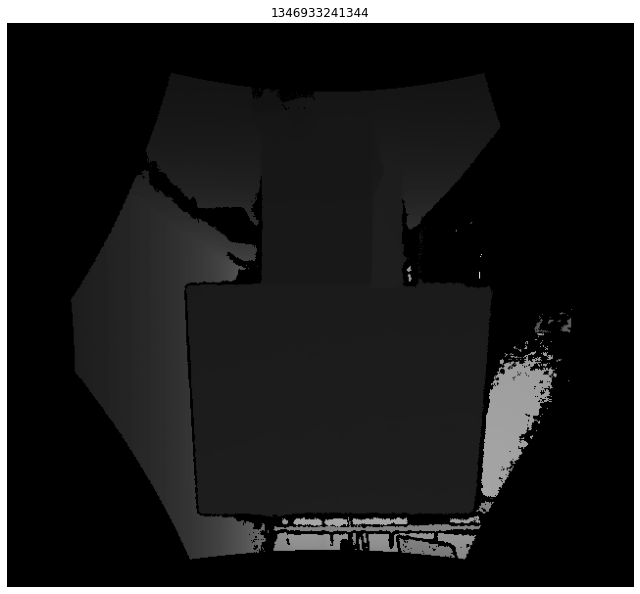

In [63]:
check_azure_depth = azure_depths[check_azure_key + depth_ext]

plot_figures({check_azure_key: check_azure_depth}, size=(9, 9))

### Detect keypoints

In [64]:
pattern_size = (8, 6)
edge_length = 0.05

In [65]:
# Detect keypoint
s10_detections = detect_keypoints(s10_images, pattern_size, edge_length)
azure_detections = detect_keypoints(azure_images, pattern_size, edge_length, invert=True)

In [66]:
# Leave only those pairs that have detections on both images
s10_det_mask = np.array([t + img_ext in s10_detections for t in s10_timestamps])
azure_det_mask = np.array([t + img_ext in azure_detections for t in azure_timestamps])

det_mask = s10_det_mask & azure_det_mask

d_s10_timestamps, d_azure_timestamps = s10_timestamps[det_mask], azure_timestamps[det_mask]

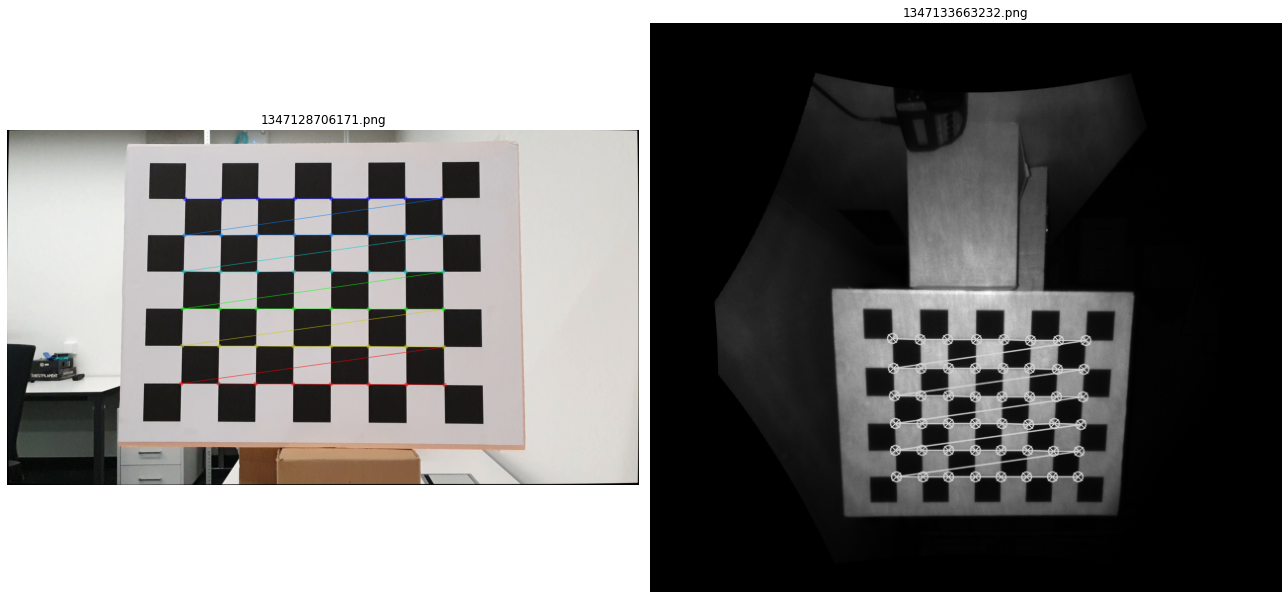

In [67]:
# Detections on azure may be innacurate. When selecting final pair make sure their detections are accurate

idx = 1

check_s10_key, check_azure_key = d_s10_timestamps[idx] + img_ext, d_azure_timestamps[idx] + img_ext


plot_figures({check_s10_key: draw_chessboard_corners(s10_images[check_s10_key], 
                                                     s10_detections[check_s10_key][1], 
                                                     pattern_size),
              check_azure_key: draw_chessboard_corners(azure_images[check_azure_key], 
                                                       azure_detections[check_azure_key][1], 
                                                       pattern_size)}, 1, 2)

### s10-to-chessboard transformation

In [68]:
# Solve PnP for find transformation between s10 keypoints and points on the board

s10_chess = {}

for ts in d_s10_timestamps:
    scene_points, kp = s10_detections[ts + img_ext]
    success, r, t = cv.solvePnP(scene_points, kp, s10_undist_intrinsics, None, flags=cv.SOLVEPNP_IPPE)
    
    if success:
        dS = np.zeros((4, 4))
        dS[:3, :3] = cv.Rodrigues(r)[0]
        dS[:3, 3] = np.reshape(t, -1)
        dS[3, 3] = 1
        
        s10_local_scene_points = to_cartesian((dS @ to_homogeneous(scene_points).transpose()).transpose())
        
        s10_chess[ts] = s10_local_scene_points


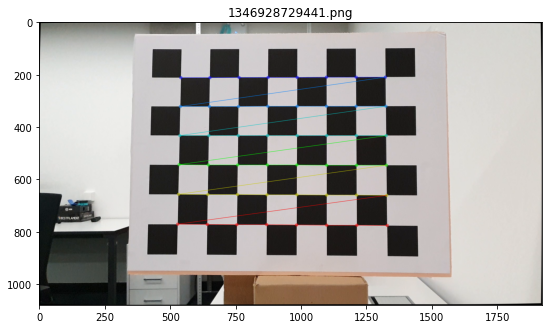

In [69]:
# Visualize transformed scene points with the estimated by PnP transformation to make sure the solution make sense
idx = 0

check_key = d_s10_timestamps[idx] + img_ext

plot_projected_keypoints(s10_images[check_key], s10_chess[check_key.split('.')[0]], s10_undist_intrinsics, check_key, pattern_size)

### azure-to-chessboard transformation

In [70]:
# Take keypoints from azure and use depth to create a point cloud out of them

azure_chess = {}

for t in d_azure_timestamps:
    kp = np.squeeze(azure_detections[t + img_ext][1], 1)
    depth = azure_depths[t + depth_ext]
    
    norm_kp = to_norm_image_coord(kp, azure_undist_intrinsics)
    
    azure_local_kp = transform2local(kp, norm_kp, depth)
    
    azure_chess[t] = azure_local_kp

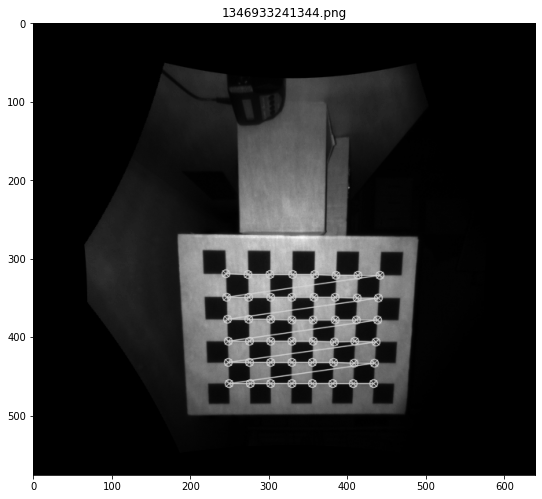

In [71]:
# Agian perform the check to make sure that obtained points are reasonable
idx = 0

check_key = d_azure_timestamps[idx] + img_ext

plot_projected_keypoints(azure_images[check_key], azure_chess[check_key.split('.')[0]], azure_undist_intrinsics, check_key, pattern_size)

In [72]:
# Visualize two chessboards next to each other and get the avg. error between corresponding points

idx = 0

check_azure_chess, check_s10_chess = azure_chess[d_azure_timestamps[idx]], s10_chess[d_s10_timestamps[idx]]

open3d.visualization.draw_geometries([to_open3d(check_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [73]:
np.linalg.norm(check_s10_chess - check_azure_chess, axis=-1).mean()

0.295209778572952

### azure-s10-extrinsics guess

In [74]:
# Estimate the point-to-point transformation between two pointclouds

extrinsics = {}

for s10_t, azure_t in zip(d_s10_timestamps, d_azure_timestamps):
    s10_chessi = s10_chess[s10_t]
    azure_chessi = azure_chess[azure_t]
    
    extrinsics[s10_t + ' ' + azure_t] = plane2plane_transformation(azure_chessi, s10_chessi)


In [75]:
# Pick only one solution (T_init) that corresponds to a pair with the best inital estimate. 
# IMPORTANT: Make sure the transformation is geometrically feasible

t_norm_p2p = []
T_p2p = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):
    azure_chessi, s10_chessi = azure_chess[azure_t], s10_chess[s10_t]
    Ti = extrinsics[s10_t + ' ' + azure_t]
    
    t_azure_chessi = to_cartesian((Ti @ to_homogeneous(azure_chessi).transpose()).transpose())
    
    t_normi = np.linalg.norm(t_azure_chessi - s10_chessi, axis=-1).mean()
    
    t_norm_p2p.append(t_normi)
    T_p2p.append(Ti)

t_norm_p2p = np.array(t_norm_p2p)
T_p2p = np.array(T_p2p)

In [76]:
t_norm_idx = np.argsort(t_norm_p2p)

T_init = T_p2p[t_norm_idx[0]]

print(T_init)

[[-0.99849781  0.00020336  0.02457967 -0.01009878]
 [ 0.00701251 -0.96965395  0.1249747  -0.04481122]
 [ 0.024147    0.12513539  0.99150296 -0.02697875]
 [ 0.          0.          0.          1.        ]]


In [77]:
# Check the selected transformation
idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess, check_s10_chess = azure_chess[check_azure_key], s10_chess[check_s10_key]

check_T = T_init

In [78]:
# 1) avg. error between points
check_t_azure_chess = to_cartesian((check_T @ to_homogeneous(check_azure_chess).transpose()).transpose())

np.linalg.norm(check_t_azure_chess - check_s10_chess, axis=-1).mean()

0.022092478678495838

In [79]:
# 2) by examining the solution visually
open3d.visualization.draw_geometries([to_open3d(check_t_azure_chess), to_open3d(check_s10_chess)])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


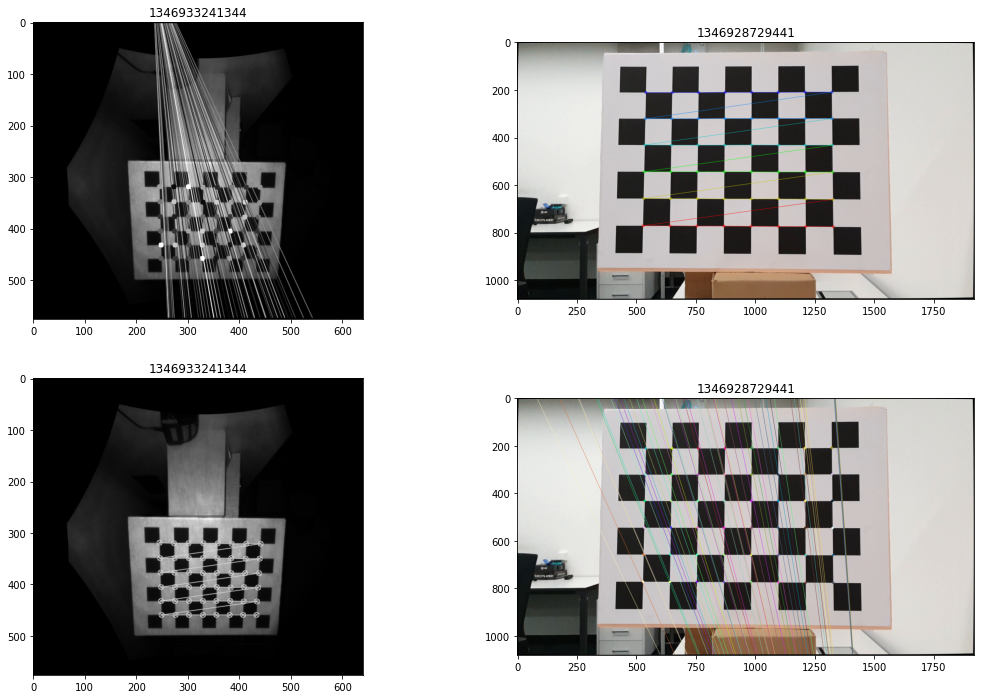

In [80]:
# 3) by plotting epipolar lines 

check_F = compose_fund_mat(check_T, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + img_ext], s10_images[check_s10_key + img_ext], 
                    azure_detections[check_azure_key + img_ext][1], s10_detections[check_s10_key + img_ext][1],
                    check_azure_key, check_s10_key, check_F, pattern_size)

In [81]:
# The initial solution as can be seen from epipolar lines is highly inaccurate thus we need to further 
# minimize avg. epipolar distance

T_opt = []

t_norm = []

for i, (s10_t, azure_t) in enumerate(zip(d_s10_timestamps, d_azure_timestamps)):    
    s10_kp, azure_kp = np.squeeze(s10_detections[s10_t + img_ext][1]), np.squeeze(azure_detections[azure_t + img_ext][1])
    local_kp1i = azure_chess[azure_t]
    
    print("Index:", i)
    
    # Do separate optimization for the initial guess to find pairs where the convergence is possible with relatively low error
    
    print("F optimization")
    
    T_opti = optimize_pose_lm(T_init, azure_kp, s10_kp, azure_undist_intrinsics, s10_undist_intrinsics)    
    
    if T_opti is not None:
        # Do optimization to find translation magnitude
        
        print("t optimization")
        
        T_opti, t_normi = optimize_translation_lm(T_opti, local_kp1i, s10_kp, s10_undist_intrinsics)
        
        T_opt.append(T_opti)
        
        t_norm.append(t_normi)
    
    print()

t_norm = np.array(t_norm)
T_opt = np.array(T_opt)
best_t_norm_idx = np.argsort(t_norm)

Index: 0
F optimization
Avg. epipolar distance: 0.16763194051365163
Number of iters: 14
t optimization
Avg. l2-norm: 0.6417919104206948
Number of iters: 27
Translation scale: -2.226126888051793

Index: 1
F optimization
Avg. epipolar distance: 0.16661235493390217
Number of iters: 14
t optimization
Avg. l2-norm: 0.6835501022569082
Number of iters: 27
Translation scale: -2.22476908610861

Index: 2
F optimization
Avg. epipolar distance: 0.1652974639353341
Number of iters: 14
t optimization
Avg. l2-norm: 0.6776447305496195
Number of iters: 27
Translation scale: -2.221949470804188

Index: 3
F optimization
Avg. epipolar distance: 0.16465316439039826
Number of iters: 14
t optimization
Avg. l2-norm: 0.648929208936237
Number of iters: 29
Translation scale: -2.221167947487675

Index: 4
F optimization
Avg. epipolar distance: 0.16186744880123527
Number of iters: 13
t optimization
Avg. l2-norm: 0.6286354359022911
Number of iters: 29
Translation scale: -2.218665075030986

Index: 5
F optimization
Avg.

Index: 54
F optimization
Avg. epipolar distance: 0.16031092545080838
Number of iters: 13
t optimization
Avg. l2-norm: 0.6818475103177134
Number of iters: 27
Translation scale: -2.2191976212545748

Index: 55
F optimization
Avg. epipolar distance: 0.16817205700015414
Number of iters: 14
t optimization
Avg. l2-norm: 0.6780803865763093
Number of iters: 27
Translation scale: -2.223166254527828

Index: 56
F optimization
Avg. epipolar distance: 0.1595695123584703
Number of iters: 13
t optimization
Avg. l2-norm: 0.6550184464929362
Number of iters: 25
Translation scale: -2.218141623349723

Index: 57
F optimization
Avg. epipolar distance: 0.17066593473850786
Number of iters: 14
t optimization
Avg. l2-norm: 0.698534598575652
Number of iters: 25
Translation scale: -2.224607260319261

Index: 58
F optimization
Avg. epipolar distance: 0.17205650159742744
Number of iters: 14
t optimization
Avg. l2-norm: 0.6464096809926042
Number of iters: 29
Translation scale: -2.222034653648178

Index: 59
F optimizat

In [82]:
print(np.arange(len(best_t_norm_idx)))
print(best_t_norm_idx)
print(t_norm[best_t_norm_idx])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]
[40 18 33 83 45 28 80 64 34  4 65 74 75 31 12 60 82 27  0  8 51 14 87 11
 58 69 37 49  3 78 46 68 56 66 19 16 76 63 21 62  7 36 29 47 89 85 22 24
 81 13 73 50 84 48 91 38 52 86 59  6 25 32 79 26 17 67 44 15 43 92  2 55
 54 20  1 70 30 41 71 61 35 10 77 23 42  5 57 39 88 72 90 53  9]
[0.61508346 0.61522836 0.6189834  0.61912361 0.62042265 0.62279291
 0.6229386  0.62317167 0.62755176 0.62863544 0.63395575 0.63566584
 0.63593444 0.6367124  0.63839878 0.63872328 0.63960328 0.64130708
 0.64179191 0.64307884 0.64310069 0.64327367 0.64386998 0.64512964
 0.64640968 0.64707608 0.64753807 0.64800785 0.64892921 0.64917485
 0.64965339 0.65371738 0.65501845 0.65660206 0.65786298 0.65960507
 0.6605764  0.66084332 0.66130

In [83]:
# Select T to examine
# np.arange(len(best_t_norm_idx))
select_idx = 0
selected_idx = best_t_norm_idx[select_idx]

print("Selected best idx:", selected_idx)
print("Selected avg. norm:", t_norm[selected_idx])

sel_T_opt = T_opt[selected_idx]

Selected best idx: 40
Selected avg. norm: 0.6150834585477865


In [84]:
sel_T_opt

array([[-0.99998083, -0.00552177,  0.0028    ,  0.00292494],
       [ 0.00524344, -0.99581932, -0.09119421,  0.10457724],
       [ 0.00329185, -0.09117778,  0.99582919,  0.05511445],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Visualize transformed keypoints, depth and tune the solution

In [85]:
# Either select one transformation or average over several of them

# T_final = average_transforms(sel_T_opt)
T_final = sel_T_opt

In [86]:
T_final

array([[-0.99998083, -0.00552177,  0.0028    ,  0.00292494],
       [ 0.00524344, -0.99581932, -0.09119421,  0.10457724],
       [ 0.00329185, -0.09117778,  0.99582919,  0.05511445],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

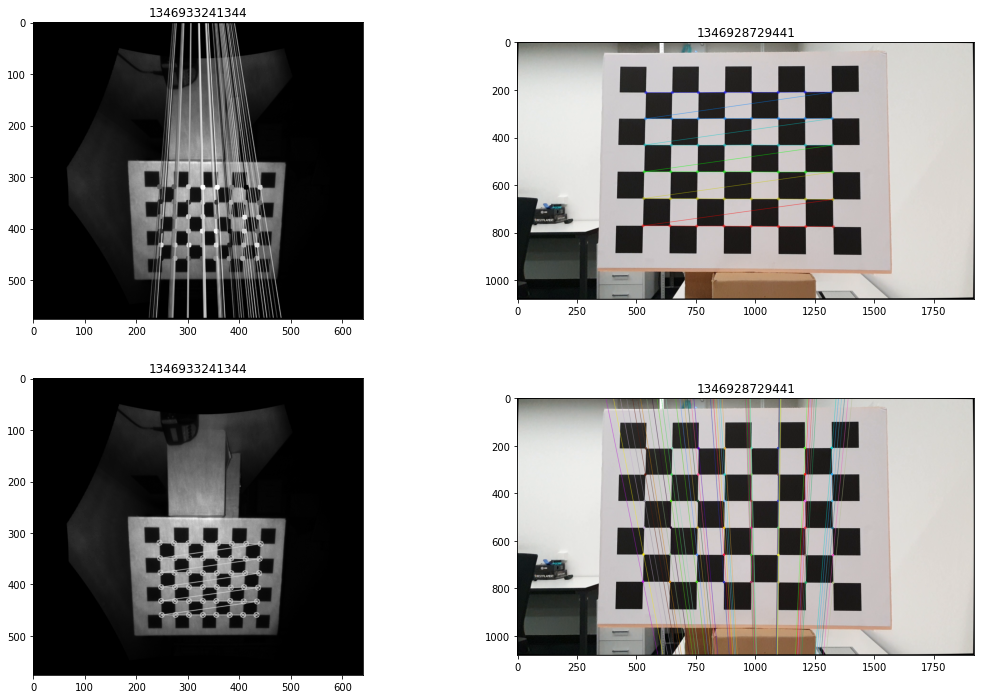

In [87]:
# Examine the solution after the optimization. Lines should be close to their corresponding points 
idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_F = compose_fund_mat(T_final, azure_undist_intrinsics, s10_undist_intrinsics)

plot_epipolar_lines(azure_images[check_azure_key + '.png'], s10_images[check_s10_key + '.png'],
                    azure_detections[check_azure_key + '.png'][1], s10_detections[check_s10_key + '.png'][1], 
                    check_azure_key, check_s10_key, check_F, pattern_size)


In [88]:
# Transform all depth measurements to a point cloud
azure_pcd_depths = pointcloudify_depths(azure_depths, azure_undist_intrinsics)

Re-proj. error:  0.6549029584566063


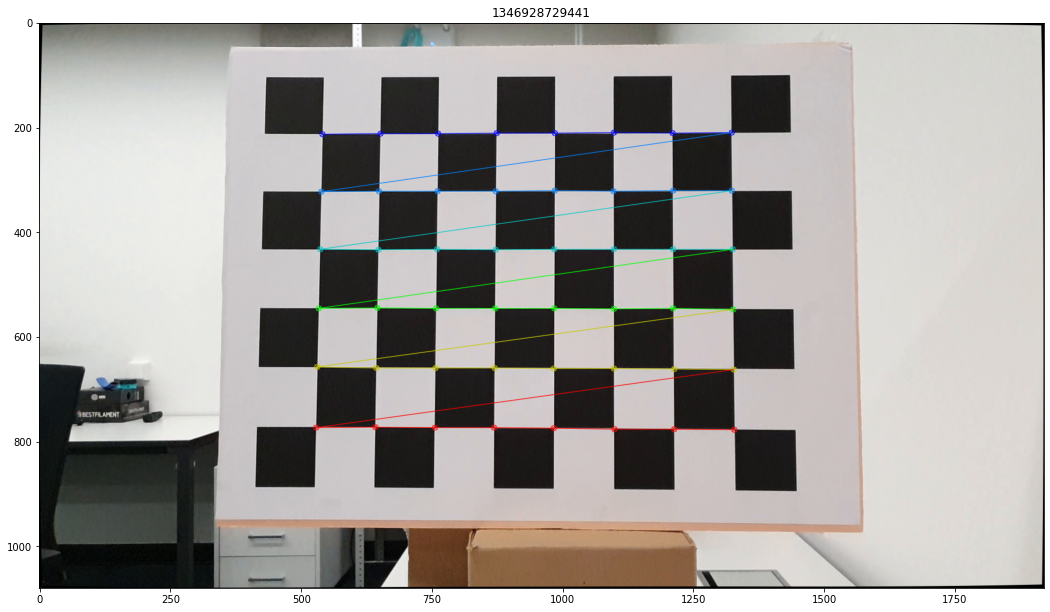

In [89]:
# Keypoints should be well aligned with their respective locations on multiple images

idx = 0

check_azure_key, check_s10_key = d_azure_timestamps[idx], d_s10_timestamps[idx]

check_azure_chess = to_cartesian((T_final @ to_homogeneous(azure_chess[check_azure_key]).transpose()).transpose())
check_s10_kp = np.squeeze(s10_detections[check_s10_key + img_ext][1], 1)

check_re_proj_error = np.linalg.norm(project2image(check_azure_chess, s10_undist_intrinsics) - check_s10_kp, axis=-1).mean()

print("Re-proj. error: ", check_re_proj_error)

plot_projected_keypoints(s10_images[check_s10_key + img_ext], check_azure_chess, 
                         s10_undist_intrinsics, check_s10_key, pattern_size, fig_size=(18, 18))


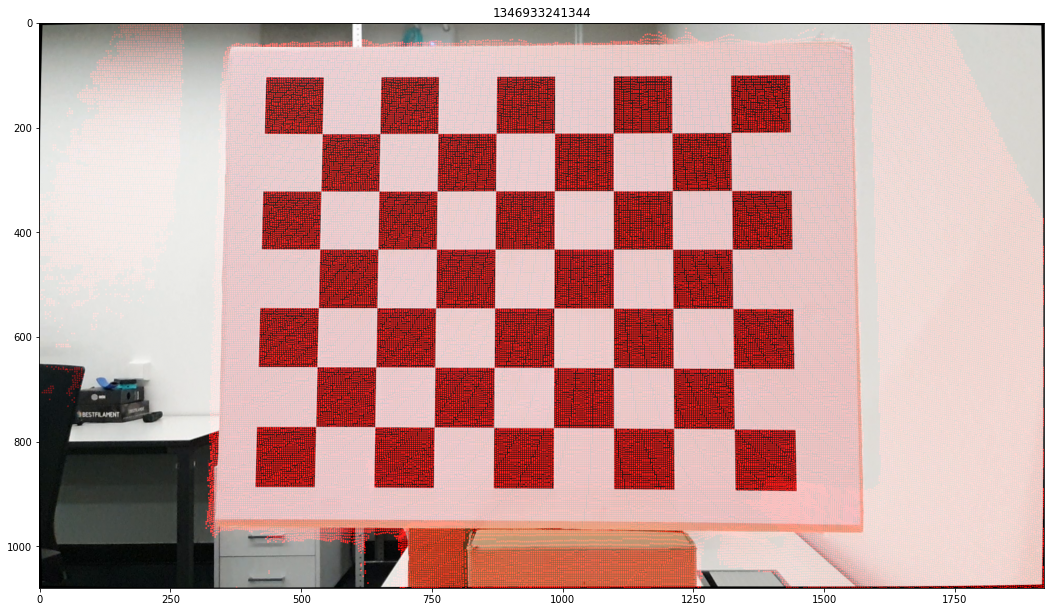

In [90]:
# Transform pointcloudified depth from azure to s10 system of coordinates and visualize it as a final check

check_azure_pcd = azure_pcd_depths[check_azure_key + depth_ext]
check_azure_pcd = to_cartesian((T_final @ to_homogeneous(check_azure_pcd).transpose()).transpose())

plot_projected_pcd(s10_images[check_s10_key + img_ext], check_azure_pcd, s10_undist_intrinsics, check_azure_key)

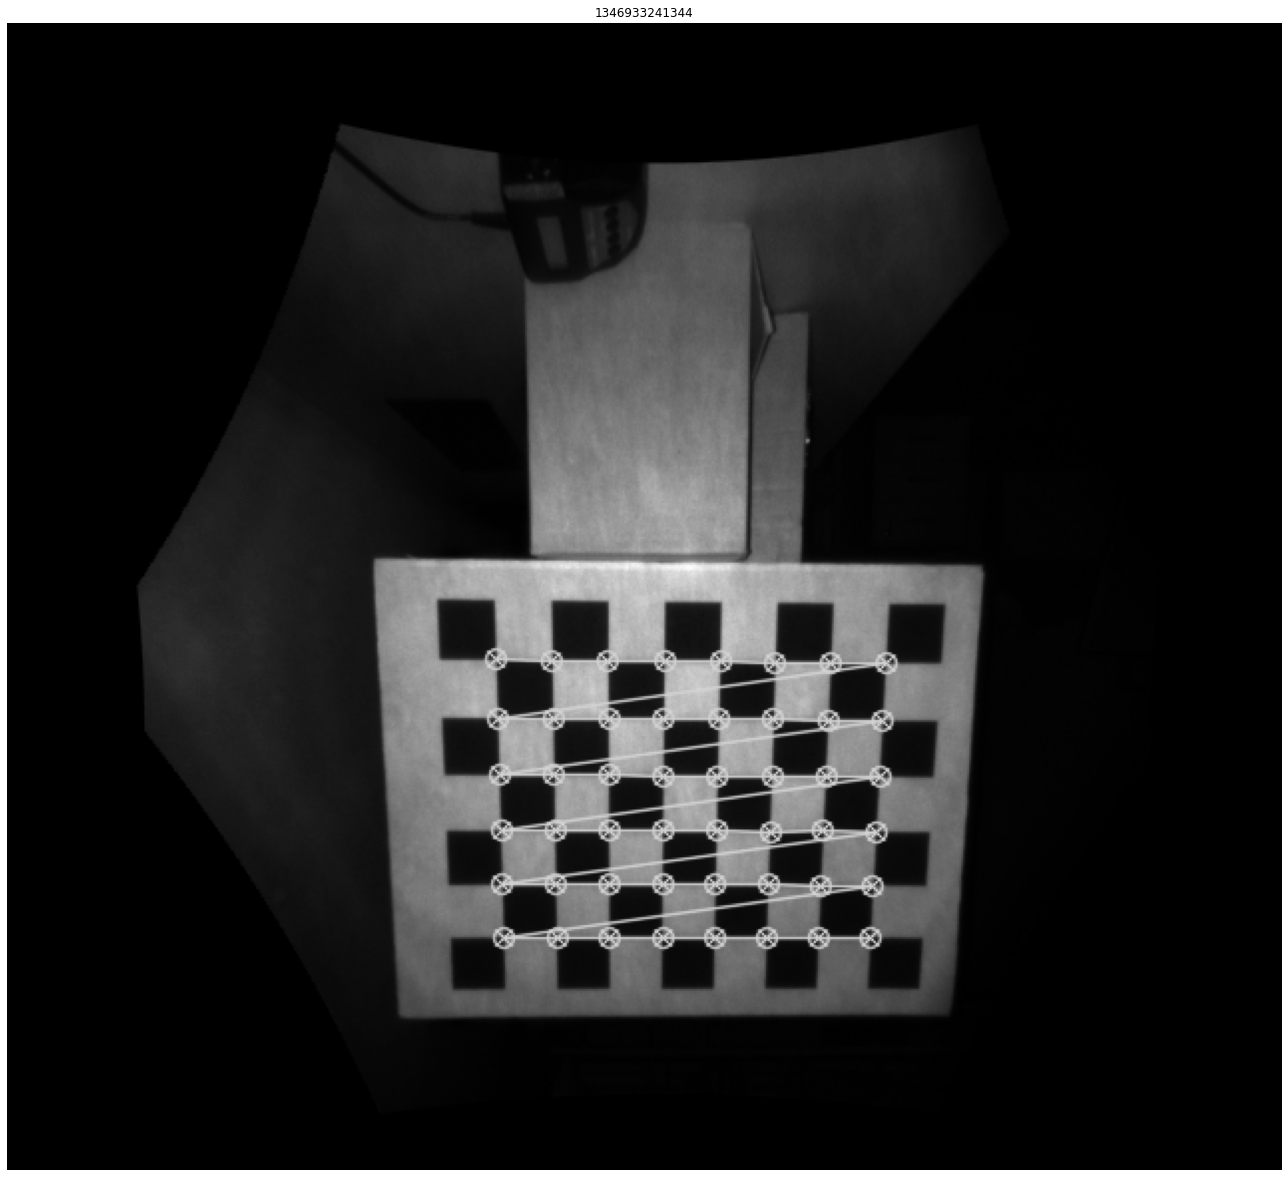

In [91]:
plot_figures({check_azure_key: draw_chessboard_corners(azure_images[check_azure_key + img_ext], 
                                                       azure_detections[check_azure_key + img_ext][1], 
                                                       pattern_size)})

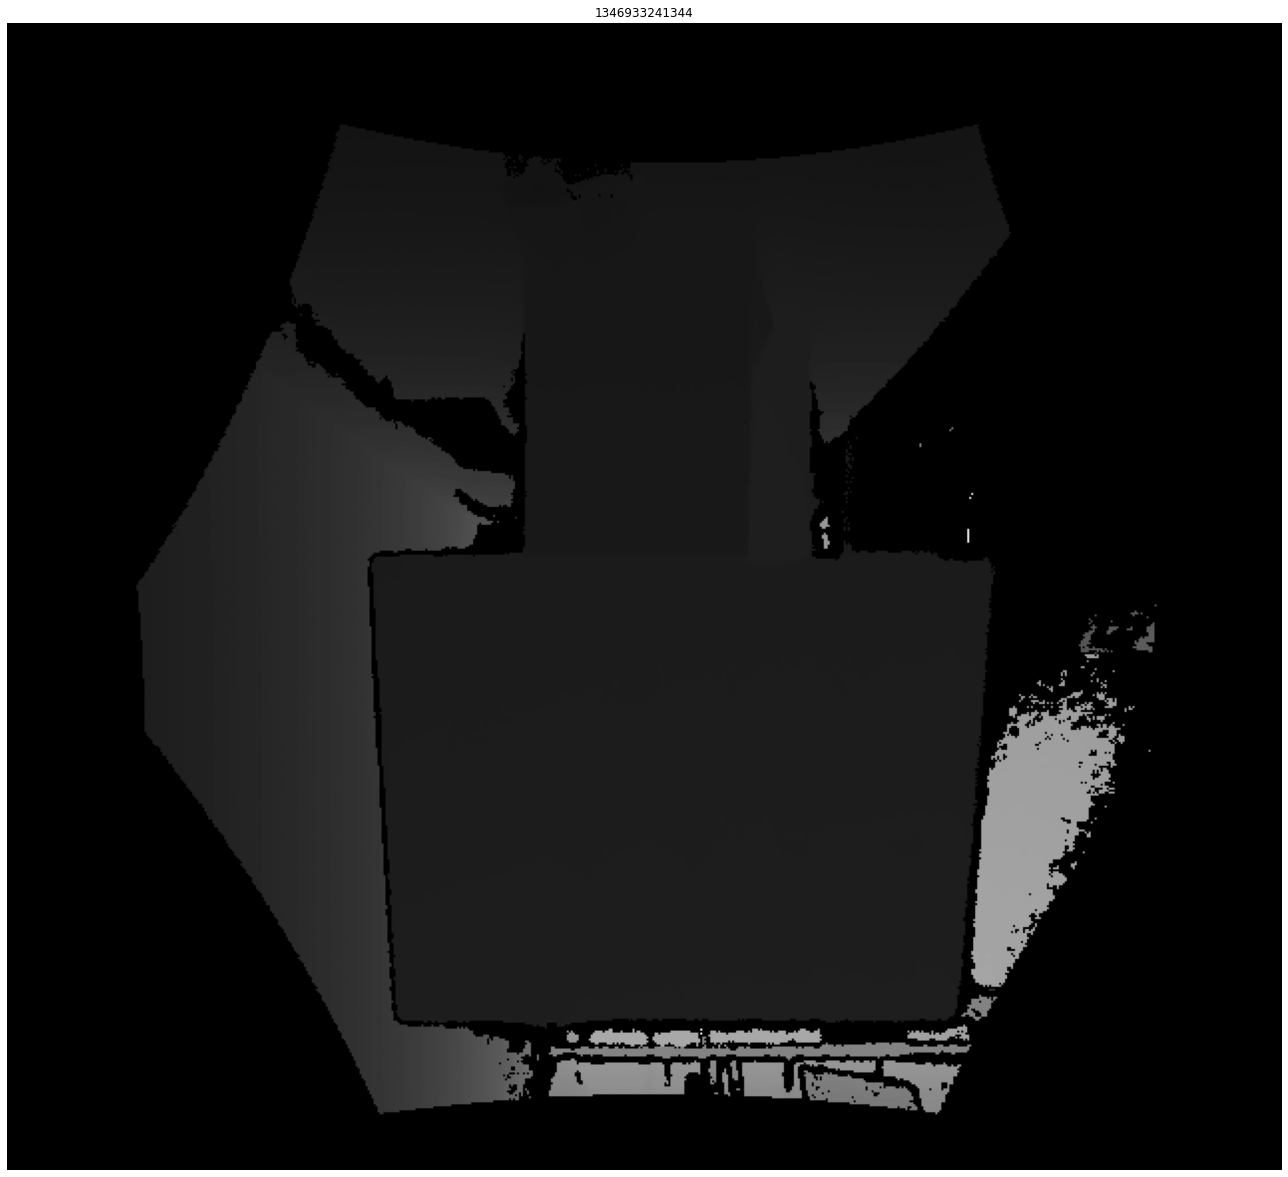

In [92]:
plot_figures({check_azure_key: azure_depths[check_azure_key + depth_ext]})

In [93]:
np.save('calib_output/azure2s10_standard_extrinsics3', T_final)

In [94]:
# Merge all the transformations together
T_1 = np.load("calib_output/azure2s10_standard_extrinsics1.npy")
T_2 = np.load("calib_output/azure2s10_standard_extrinsics2.npy")
T_3 = np.load("calib_output/azure2s10_standard_extrinsics3.npy")

T_avg = average_transforms([T_1, T_2, T_3])

In [95]:
T_avg

array([[-0.99998813, -0.00486804, -0.00019747,  0.00619728],
       [ 0.00486541, -0.99569084, -0.09260707,  0.10634413],
       [ 0.0002542 , -0.09260693,  0.99570271,  0.05728305],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [96]:
np.save('calib_output/azure2s10_standard_extrinsics', T_avg)